In [1]:
import math, time
import torch

In [2]:
import os
import sys
sys.path.append('../..')
from functions.get_data import data_n_loaders
LAB_DIR = os.environ['USERDIR']
DATA_PATH = LAB_DIR+'/data'
dataname = '2dgaussian_diffmag'
batch_size = 512
_, _,train_data, _, mean, scale = data_n_loaders(dataname, batch_size, return_data=True, \
      data_path=DATA_PATH, standardise_data = True, return_transform=True)
mean = mean.squeeze()
train_data_raw = (train_data.data/scale) + mean

/n/home00/sumedh/spmax_sae/experiments/expt19_separability_diffmag2/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)

In [3]:
torch.manual_seed(0)
#sample equal number of points from each class, get a decent subset of data
numpoints_perconcept = 1000
num_concepts = 6
data_subset_perconcept = []
labels_subset_perconcept = []
for i in range(num_concepts):
    indices = train_data.labels == i
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data_raw[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
data_subset_raw = torch.cat(data_subset_perconcept, dim=0)
data_subset = (data_subset_raw - mean) * scale #transform same as training data (to input to model)
labels_subset = torch.cat(labels_subset_perconcept, dim=0)

/tmp/ipykernel_1761149/3512491419.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])


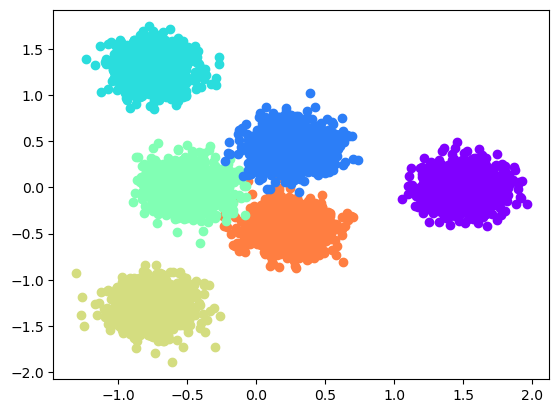

In [4]:
import matplotlib.pyplot as plt
# colors_concept = ['m', 'b', 'g', 'r', 'y']
#get 6 colors from cmap rainbow
cmap = plt.get_cmap('rainbow')
colors_concept = [cmap(i/num_concepts) for i in range(num_concepts)]
for k in range(num_concepts):
    data_k = data_subset_raw[labels_subset==(num_concepts-k-1),:]
    # plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])
    plt.scatter(data_k[:,0], data_k[:,1], c=colors_concept[num_concepts-1-k])
    # plt.xlim(-4, 8)
    # plt.ylim(-8, 6)

In [5]:
exptnames = [f'onset762_relu_021725', f'geek630_jumprelu_021725', \
    f'ice764_topk_relu_k15_021725', f'usage523_spade_021725']
saetypes = ['relu', 'jumprelu', 'topk_relu', 'sparsemax_dist']
kvals_all = [0, 0, 15, 0]
from models import SAE
width = 50 #of sae
modelsall = []
dimdata = 2
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True
    modeli = SAE(dimdata, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_8204epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli)

/tmp/ipykernel_1761149/1681308858.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_8204epochs.pt")

In [6]:
latent_reps_all = [] #latent reps on data subset for each model
device = 'cuda'
for i in range(len(exptnames)):
    modeli = modelsall[i].to(device)
    with torch.no_grad():
        pts_recon, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        latent_reps_all.append(latent_reps.detach().cpu())

In [7]:
#get f1 score of each latent for each class

eps = 1e-12

f1_all = torch.zeros((len(exptnames), num_concepts, width))
precision_all = torch.zeros((len(exptnames), num_concepts, width))
recall_all = torch.zeros((len(exptnames), num_concepts, width))

for i in range(len(exptnames)):
    for c in range(num_concepts):
        latents_i = latent_reps_all[i]
        threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
        truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
        falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
        allpos = (labels_subset==c).sum().float()
        pospred = (latents_i>threshold).sum(0).float()
        precision = truepos/(pospred+eps)
        recall = truepos/(allpos+eps)
        f1 = 2*precision*recall/(precision+recall+eps)
        f1_all[i,c, :] = f1
        precision_all[i,c, :] = precision
        recall_all[i,c, :] = recall
monosemantic_latents = torch.argmax(f1_all, dim=-1)

In [8]:
ordered_latents = torch.argsort(f1_all, dim=-1, descending=True)

In [9]:
f1_sorted = torch.gather(f1_all, dim=-1, index=ordered_latents)
precision_sorted = torch.gather(precision_all, dim=-1, index=ordered_latents)
recall_sorted = torch.gather(recall_all, dim=-1, index=ordered_latents)

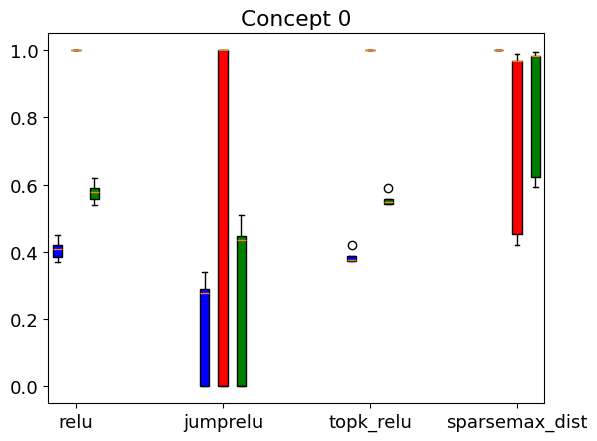

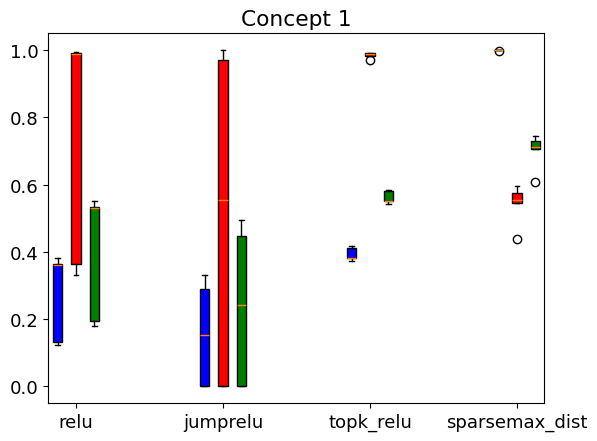

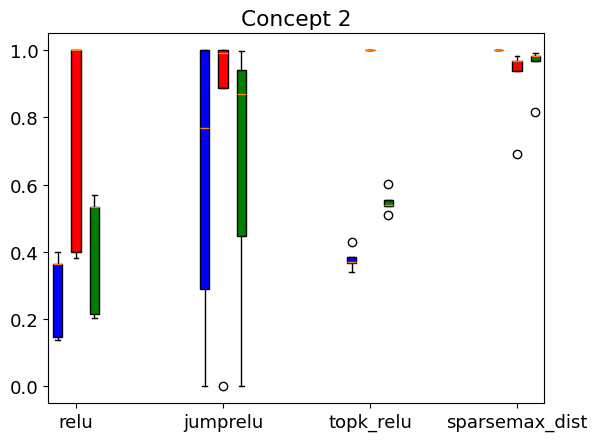

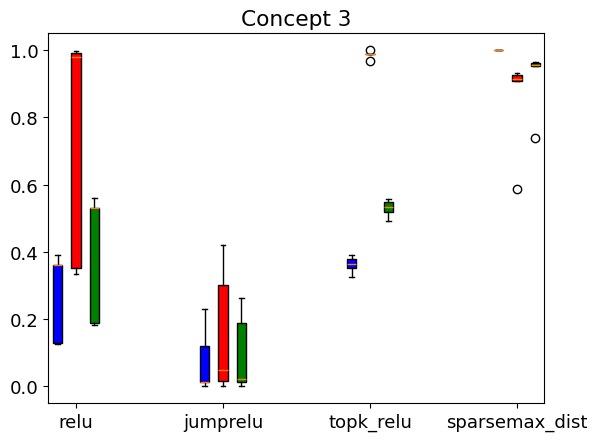

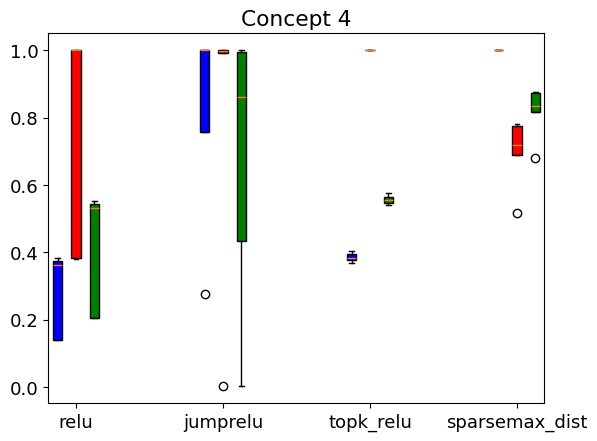

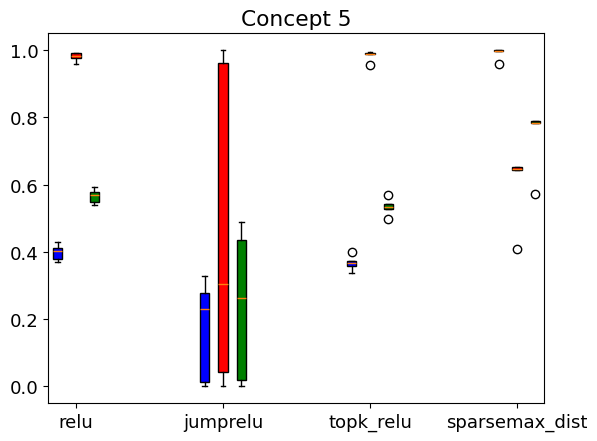

In [15]:
colors_scores = ['b', 'r', 'g']
shownum = 5 #topk most monosemantic latents' precision, recall and f1 scores
gap = 8
for i in range(num_concepts):
    #draw boxplots for precision, recall, f1 score of each sae (grouped together per sae, xlabels must be saenames)
    plt.figure()
    p = plt.boxplot(precision_sorted[:,i,:shownum], positions=[1, 1+gap, 1+2*gap, 1+3*gap], patch_artist=True)
    r = plt.boxplot(recall_sorted[:,i,:shownum], positions=[2, 2+gap, 2+2*gap, 2+3*gap], patch_artist=True)
    f = plt.boxplot(f1_sorted[:,i,:shownum], positions=[3, 3+gap, 3+2*gap, 3+3*gap], patch_artist=True)   
    for pc in p['boxes']:
        pc.set_facecolor(colors_scores[0])
    for pc in r['boxes']:
        pc.set_facecolor(colors_scores[1])
    for pc in f['boxes']:
        pc.set_facecolor(colors_scores[2]) 
    plt.xticks([2, 2+gap, 2+2*gap, 2+3*gap], saetypes)
    plt.title(f'Concept {i}')
    # plt.yscale('log')
    # plt.title(f'Concept {i} f1 score')
    plt.show()
    

In [11]:
xlims = [-2, 2]
ylims = [-2, 2]
numpoints_axis = 1000
x, y = torch.meshgrid(torch.linspace(xlims[0], xlims[1], numpoints_axis), torch.linspace(ylims[0], ylims[1], numpoints_axis))
Xmesh_raw = torch.stack([x, y], dim=2).view(-1, 2)
Xmesh = scale*(Xmesh_raw - mean.reshape((1, 2))) #transform to pass to the model

/n/holylabs/LABS/ba_lab/Users/sumedh/conda/envs/spmax/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:

from functions.utils import linear_pieces

rfall = []
heatall = []

for i in range(len(exptnames)):
    with torch.no_grad():
        modeli = modelsall[i]
        _, latents = modeli(Xmesh.to(device), return_hidden=True)
        latents_s = latents.reshape((numpoints_axis, numpoints_axis, width)).T
        latents_s = latents_s.detach().cpu()
        rfall.append((latents_s>1e-6).float())
        heatall.append(latents_s)

/tmp/ipykernel_1761149/1138805501.py:10: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  latents_s = latents.reshape((numpoints_axis, numpoints_axis, width)).T


In [13]:
import numpy as np
np.array(colors_concept[3]).tolist()

[0.503921568627451, 0.9999810273487268, 0.7049255469061472, 1.0]

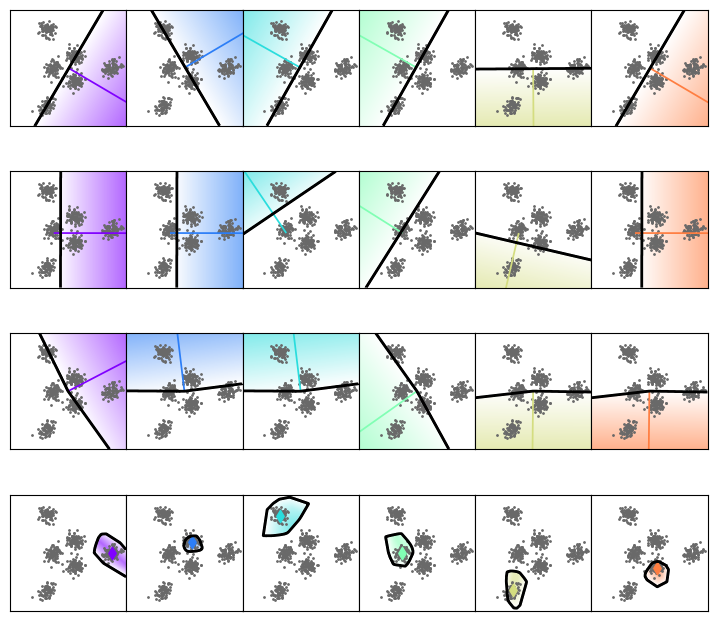

In [14]:
#show only final receptive fields for all models, data in separate figures, each having 4X5 subplots (one per neuron)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

fig, axs = plt.subplots(len(exptnames), num_concepts, figsize=(3*3, 3*2.8))
torch.manual_seed(0)
concept_names = ['Concept '+str(i) for i in range(num_concepts)]
colors_names = {'blue':'#377eb8', 'orange':'#ff7f00', 'green':'#4daf4a', 'red':'#e41a1c', 'purple':'#984ea3'}
# colors_concepts = [colors_names['green'], colors_names['blue'], colors_names['orange'], colors_names['purple'], colors_names['red']]
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap that interpolates from white to your desired color
colormaps = []
for k in range(num_concepts):
    custom_cmap = LinearSegmentedColormap.from_list("custom", ["white", np.array(colors_concept[k]).tolist()])
    colormaps.append(custom_cmap)
indices = torch.randperm(len(data_subset))[:500]
for j in range(len(exptnames)):
    for k in range(num_concepts):
        axs[j, k].scatter(data_subset_raw[indices,0], data_subset_raw[indices,1], \
            s=1, c='dimgray')
        heatjk = heatall[j][monosemantic_latents[j,k].item(),:,:]
        axs[j,k].imshow(heatjk, alpha=0.6,
            extent=[xlims[0], xlims[1], ylims[0], ylims[1]], origin='lower', cmap=colormaps[k])
        axs[j,k].set_xticks([])
        axs[j,k].set_yticks([])
        axs[j,k].set_xlim(*xlims)
        axs[j,k].set_ylim(*ylims)
        axs[j,k].contour(heatjk, levels=[torch.quantile(heatjk.flatten(), 0.1).item()], colors='k', \
            linewidths=2, extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
        # if j==len(exptnames)-1: #sparsemax
        protos = modelsall[j].Ae.detach().cpu()
        
        latentid = monosemantic_latents[j,k].item()
        if j==len(exptnames)-1:
            protos = protos/scale + mean
            axs[j,k].scatter(protos[latentid,0], protos[latentid,1], marker='d', color=np.array(colors_concept[k]).tolist(), s=40)
        else:
            protos = protos*scale
            protos = protos/(1e-12+ protos.norm(dim=1, keepdim=True))
            bdec = modelsall[j].bd.detach().cpu().squeeze()
            bdec = bdec/scale + mean
            
            axs[j,k].quiver(bdec[0], bdec[1], protos[latentid,0], protos[latentid,1], scale=0.2, scale_units='xy', angles='xy', \
                color=np.array(colors_concept[k]).tolist(), width=0.015)
fig.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("./figs/recfield_heatmaps.pdf", dpi=300, bbox_inches='tight')

plt.show()